<a href="https://colab.research.google.com/github/ravivarmakumar/INFO-5505-Spring-2022/blob/main/RaviVarmaKumarBevara_INFO5505_Assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO-5505 Applied Machine Learning for Data Scientists


### Assignment 4 - Navie Bayes Learning


- Name: Ravi Varma Kumar Bevara
- Student ID : 11476678

**Navie Bayes Classifier**
<font color='red'>
> A Naive Bayes classifier is a probabilistic machine learning model that’s used for classification task. The crux of the classifier is based on the Bayes theorem.
<br />
</font>


Bayes Theorem -

\begin{equation*}
P(A/B) = \frac{P(B/A)*P(A)}{P(B)}
\end{equation*}

- Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. 
- The assumption made here is that the predictors/features are independent. That is presence of one particular feature does not affect the other. Hence it is called naive.
- Naive Bayes algorithms are mostly used in sentiment analysis, spam filtering, recommendation systems etc. 
- They are fast and easy to implement but their biggest disadvantage is that the requirement of predictors to be independent. 
- In most of the real life cases, the predictors are dependent, this hinders the performance of the classifier.



#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from scipy import stats
import operator

For the dataset, I decided to save the data on the cloud which is google drive, It would be compactable with google cloab

####Mounting my google drive for the dataset access

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def read_documents(doc_file):   
    doc = []
    label = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            doc.append(words[3:]) 
            label.append(words[1])
    return doc, label

In [4]:
rawdata_docs, rawdata_labels = read_documents('drive/MyDrive/INFO5505-Spring2022/converted_all_sentiment_shuffled.txt')

####Exploratory Data Analysis


In [5]:
rawdata = pd.DataFrame({'doc':rawdata_docs,'label':rawdata_labels})
rawdata.head()

,doc,label
0,"[i, bought, this, album, because, i, loved, th...",neg
1,"[i, was, misled, and, thought, i, was, buying,...",neg
2,"[i, have, introduced, many, of, my, ell, ,, hi...",neg
3,"[anything, you, purchase, in, the, left, behin...",pos
4,"[i, loved, these, movies, ,, and, i, cant, wia...",pos


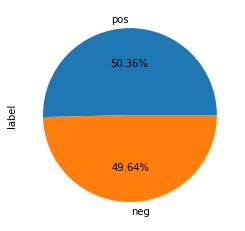

In [6]:
rawdata['label'].value_counts().plot.pie(autopct="%.2f%%")

In [7]:
rawdata.shape

(11914, 2)

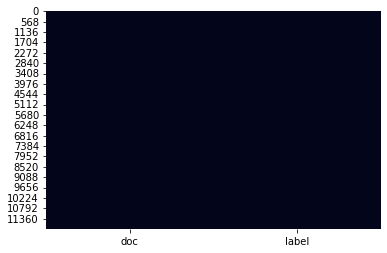

In [8]:
sns.heatmap(rawdata.isnull(), cbar=False)

In [9]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   doc     11914 non-null  object
 1   label   11914 non-null  object
dtypes: object(2)
memory usage: 186.3+ KB


In [10]:
def docsToText(docs):
  texts =[]
  for doc in docs:
    str = ""
    for element in doc:
      string = " "+element
      str += string
    texts.append(str)
  return texts

In [11]:
rawdata['doc'] = docsToText(rawdata['doc'])

#### Wordcloud for Positive and Negative Words

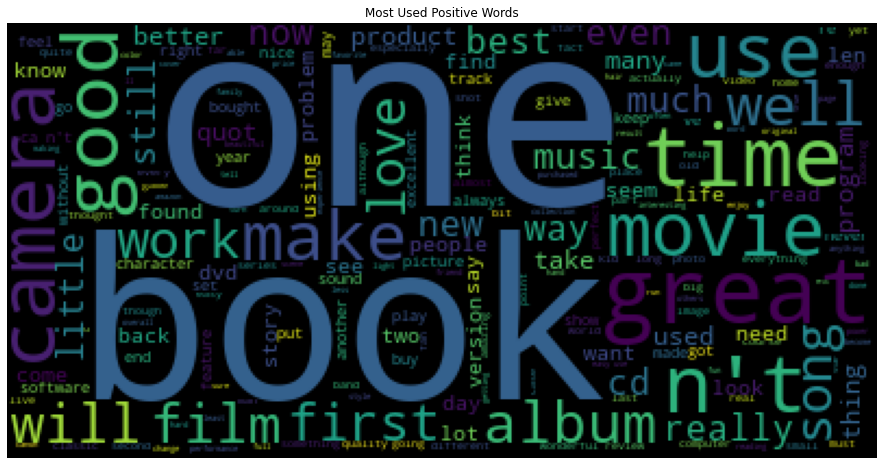

In [12]:
positiveWords =' '.join([text for text in rawdata['doc'][rawdata['label'] == 'pos']])
wordcloud = WordCloud().generate(positiveWords)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most Used Positive Words")
plt.show()

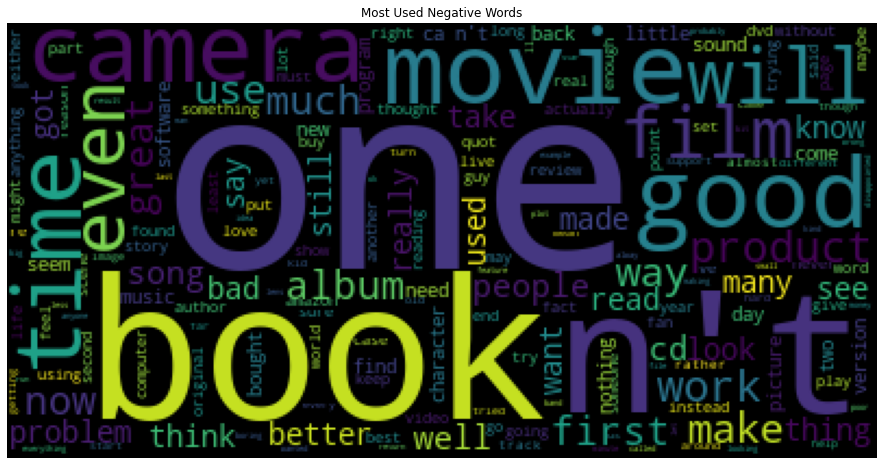

In [13]:
negativeWords =' '.join([text for text in rawdata['doc'][rawdata['label'] == 'neg']])
wordcloud = WordCloud().generate(negativeWords)
plt.figure(figsize=(20, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Most Used Negative Words")
plt.show()

#### Splitting the Dataset into Train and Test data

In [14]:
def document_split(x, y, split_percentage):
      split_point = int((1-split_percentage)*len(rawdata_docs))
      train_docs = rawdata_docs[:split_point]
      train_labels = rawdata_labels[:split_point]  
      eval_docs = rawdata_docs[split_point:]
      eval_labels = rawdata_labels[split_point:]
      return train_docs, train_labels, eval_docs, eval_labels

In [15]:
train_docs, train_labels, test_docs, test_labels = document_split(rawdata_docs, rawdata_labels, 0.20)

#### Model Training

In [16]:
def train_nb(documents, labels): 
    indexesOfLabels, countOfLabels, percentageOfLabels = ({} for _ in range(3))
    for k in set(labels):       
        indexesOfLabels[k] = np.where(np.array(labels)==k)
        stopWords = ['.',',','"','(',')','the','and','to','is','a','it','this','that','of','i','you','in','for',"'s"]
        countOfLabels[k] = Counter(w for doc in np.array(documents, dtype=object)[indexesOfLabels[k]] for w in doc if w not in stopWords)
        countOfLabels[k]['UNKNOWN'] = 1
        
        totalNumberOfLabels = sum(list(countOfLabels[k].values()))
        percentageOfLabels[k] = len(np.array(documents, dtype=object)[indexesOfLabels[k]]) / len(documents)
    
        for key in countOfLabels[k]:
            countOfLabels[k][key] = np.log((countOfLabels[k][key]+1)/(totalNumberOfLabels+len(countOfLabels[k])))
    return countOfLabels, percentageOfLabels

In [17]:
countOfLabels, percentageOfLabels =  train_nb(train_docs, train_labels)

In [18]:
def logValuesOfPredictions(document, label, countOfLabels, percentageOfLabels):
    labels = countOfLabels[label]
    keys = len(labels)
    logarithmicValues = {}
    logarithmicValues[tuple(document)] = 0
    for i in document:
        if labels[i] != 0:
            logarithmicValues[tuple(document)] += labels[i]
        else:
            logarithmicValues[tuple(document)] += countOfLabels[label]['UNKNOWN']
    logarithmicValues[tuple(document)] += np.log(percentageOfLabels[label])  
    return list(logarithmicValues.values())

In [19]:
def classify_nb(document, countOfLabels, initals):
    probabilitiesOfPredictions = {}
    for key in countOfLabels.keys():
        probabilitiesOfPredictions[key] = logValuesOfPredictions(document, key, countOfLabels, percentageOfLabels)
    return max(probabilitiesOfPredictions.items(), key=operator.itemgetter(1))[0]

#### Testing the classifer with custom sentences

In [20]:
classify_nb(['ravi','is','not','liking','this','course'],countOfLabels,percentageOfLabels)

'neg'

In [21]:
classify_nb(['ravi','did','enjoys','this','course'],countOfLabels,percentageOfLabels)

'pos'

#### Model Evaluation

In [22]:
def evaluation_nb(docs, countOfLabels, percentageOfLabels):
    finalPredictions = [classify_nb(doc, countOfLabels,percentageOfLabels) for doc in docs]
    return finalPredictions

In [23]:
model_predictions = evaluation_nb(test_docs, countOfLabels, percentageOfLabels)

#### Accuracy

In [24]:
def accuracy(true_labels, predicted_labels):
    return np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)

In [25]:
print("Accuracy of the NaiveBayes Classifier: " + str(round(accuracy(test_labels, model_predictions)*100,2)) + " % ")

Accuracy of the NaiveBayes Classifier: 82.04 % 


#### Error Analysis

In [26]:
indexesOfLabels = np.where(np.array(test_labels)!=np.array(model_predictions))

In [27]:
wrongPredictions = pd.DataFrame(np.column_stack([np.array(test_docs,dtype=object)[indexesOfLabels], np.array(model_predictions)[indexesOfLabels]]), columns=['doc','badLabel'])

In [28]:
wrongPredictions['positiveLogarithimcProbability'] = pd.Series(logValuesOfPredictions(document, 'pos', countOfLabels,percentageOfLabels)[0] for document in wrongPredictions.iloc[:,0])
wrongPredictions['negativeLogarithimcProbability'] = pd.Series(logValuesOfPredictions(document, 'neg', countOfLabels, percentageOfLabels)[0] for document in wrongPredictions.iloc[:,0])
wrongPredictions['absoluteDifference'] = np.abs(wrongPredictions['positiveLogarithimcProbability']-wrongPredictions['negativeLogarithimcProbability'])

In [29]:
wrongPredictions.sort_values('absoluteDifference', ascending=True)

,doc,badLabel,positiveLogarithimcProbability,negativeLogarithimcProbability,absoluteDifference
53,"[i, love, the, firm, workouts, ,, and, i, love...",pos,-1565.408410,-1565.414580,0.006170
123,"[the, pressure, on, the, rain, setting, is, so...",pos,-753.863680,-753.878139,0.014458
102,"[why, are, the, newer, products, getting, slow...",pos,-984.702142,-984.720672,0.018530
308,"[this, cd, is, ,, without, a, doubt, amazing, ...",pos,-777.804985,-777.834094,0.029110
41,"[jet, li, as, a, contrac, killer, ?, come, on,...",pos,-405.946571,-405.981259,0.034688
...,...,...,...,...,...
17,"[the, decalogue, is, one, of, several, excelle...",pos,-6922.689505,-6957.213093,34.523588
219,"[i, installed, norton, antivirus, 2007, immedi...",neg,-2993.978151,-2953.929015,40.049136
141,"[i, grew, up, reading, harold, evan, 's, sunda...",pos,-12189.457923,-12243.023237,53.565314
226,"[i, 've, been, using, norton, antivirus, 2002,...",neg,-4675.799856,-4610.115068,65.684788


#### Model Validation using 10-Fold Cross Validation

In [30]:
def crossValidation(documents,labels,percentageOfLabels, N=10):
    totalCorrectPredictions = 0
    totalPredictions = 0    
    for fold in range(N):     
        fold_start = int(fold * (int(len(documents))/N))
        fold_end = int((fold+1) * (int(len(documents))/N))
        train_docs_fold = documents[:fold_start] + documents[fold_end:]
        train_labels_fold = labels[:fold_start] + labels[fold_end:]
        test_docs_fold = documents[fold_start:fold_end]
        test_labels_fold = labels[fold_start:fold_end]
        countOfLabels, percentageOfLabels = train_nb(train_docs_fold, train_labels_fold)
        modelPredictions = evaluation_nb(test_docs_fold, countOfLabels, percentageOfLabels)
        modelAccuracy = accuracy(test_labels_fold, modelPredictions)  
        toalTestLabels = len(test_labels_fold)
        correctPredictions = np.sum(np.array(test_labels_fold, dtype=object) == np.array(modelPredictions))
        totalCorrectPredictions += correctPredictions
        totalPredictions += toalTestLabels
        
    intervalEstimate = stats.beta(totalCorrectPredictions + 1, totalPredictions-totalCorrectPredictions + 1)
    lowerEnd, higherEnd = intervalEstimate.interval(0.95)
    
    return totalCorrectPredictions, totalPredictions, totalCorrectPredictions/totalPredictions, [lowerEnd,higherEnd]

In [31]:
totalCorrectPredictions, totalPredictions, newAccuracy, intervalEstimate = crossValidation(rawdata_docs, rawdata_labels,percentageOfLabels)

In [32]:
print("New Accuracy of the NaiveBayes Classifier with 10-Fold Validation: " + str(round(newAccuracy*100,2)) + " % ")
print("New Interval Estimate of the NaiveBayes Classifier with 10-Fold Validation: " + str(intervalEstimate))

New Accuracy of the NaiveBayes Classifier with 10-Fold Validation: 81.47 % 
New Interval Estimate of the NaiveBayes Classifier with 10-Fold Validation: [0.807592149774242, 0.8215458196579987]
